# Model: Trackster neighborhood approach

Input:
- graph of tracksters in the cone neighbourhood.
- list of edges
- label 1 or 0 for each edge

Options:
- use EdgeConv operators to extract information from the neighborhood
    - then predict binary output per edge
- try: use DGCNN to let the network make its own edges in the latent space
    - force the original edges in the last conv layer to get the same output?

Use the batch trick to encode multiple samples at once (need to reindex edges).
- start with batch size 1 to make this easier

In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import SGD

import torch.nn.functional as F

import numpy as np

from torch_geometric.nn import EdgeConv
import torch_geometric.utils as geo_utils

import sklearn.metrics as metrics

from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler

from reco.learn import train_edge_pred, test_edge_pred
from reco.dataset import TracksterGraph
from reco.loss import FocalLoss

import itertools


# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

In [2]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    MAX_DISTANCE=10,
    ENERGY_THRESHOLD=10,
    include_graph_features=False,
)

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
def get_graph_feature(x, edge_list):
    batch_size = x.size(0)
    num_points = x.size(2)

    x = x.view(batch_size, -1, num_points)
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

In [146]:
class GraphNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1, aggr='add', dropout=0.2):
        super(GraphNet, self).__init__()
                
        # Feature transformation to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        convnetwork1 = nn.Sequential(
            nn.Linear(2* hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        convnetwork2 = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv1 = EdgeConv(nn=convnetwork1, aggr=aggr)
        self.graphconv2 = EdgeConv(nn=convnetwork2, aggr=aggr)

        # Edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, edge_index):        
        H = self.inputnetwork(X)
        (prepared_edges, _) = geo_utils.add_self_loops(edge_index)

        H = self.graphconv1(H, geo_utils.to_undirected(prepared_edges))
        H = self.graphconv2(H, geo_utils.to_undirected(prepared_edges))
        
        src, dst = edge_index
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [147]:
np.array(ds[0][0]).shape

(39, 15)

In [148]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

Train samples: 900, Test samples: 99


In [149]:
def flat_data_loader(dataset, batch_size):
    gen = DataLoader(dataset, batch_size=1, shuffle=True)

    buffer = []
    for sample in gen:
        buffer.append(sample)
        
        if len(buffer) != batch_size:
            continue

        datapoints = []
        labels = []
        edge_list = []

        # loop over the batch
        for X, edges, Y in buffer:

            # offset the edge index
            dp_len = len(datapoints)

            # get rid of the batch dimension
            datapoints.append(X[0])
            labels.append(Y[0])

            for (a, b) in edges[0]:
                edge_list.append((a + dp_len, b + dp_len))
        
        buffer.clear()
        yield torch.vstack(datapoints).type(torch.float), torch.tensor(edge_list), torch.hstack(labels)


ds_shape = test_set[0][0].shape
print(ds_shape)

torch.Size([40, 15])


In [150]:
scaler = StandardScaler()
all_x = torch.concat([ts for ts, _, _ in train_set])
scaler.fit(all_x)

train_set_scaled = [(scaler.transform(ts), el, y) for ts, el, y in train_set]
test_set_scaled = [(scaler.transform(ts), el, y) for ts, el, y in test_set]

In [151]:
model = GraphNet(input_dim=ds_shape[1])

epochs = 10

# loss_func = F.binary_cross_entropy_with_logits
loss_func = FocalLoss(alpha=0.25, gamma=2)


model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):
    print(f'Epoch {epoch}:')

    batch_size = 1
    train_dl = flat_data_loader(train_set_scaled, batch_size)
    test_dl = flat_data_loader(test_set_scaled, batch_size)

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl,
        batch_size
    )
    
    train_acc = metrics.accuracy_score(train_true, (train_pred > 0.5).astype(int))

    print(f'\ttrain loss:\t{train_loss:.2f}\ttrain acc: {train_acc:.2f}')
    scheduler.step()

    test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl, batch_size)
    test_acc = metrics.accuracy_score(test_true, (test_pred > 0.5).astype(int))

    print(f'\t test loss:\t{test_loss:.2f}\ttest acc: {test_acc:.2f}')

Epoch 0:
	train loss:	49.08	train acc: 0.79
	 test loss:	3.78	test acc: 0.83
Epoch 1:
	train loss:	32.89	train acc: 0.83
	 test loss:	3.13	test acc: 0.85
Epoch 2:
	train loss:	26.46	train acc: 0.85
	 test loss:	2.69	test acc: 0.86
Epoch 3:
	train loss:	23.06	train acc: 0.86
	 test loss:	2.81	test acc: 0.86
Epoch 4:
	train loss:	20.33	train acc: 0.87
	 test loss:	2.07	test acc: 0.87
Epoch 5:
	train loss:	18.65	train acc: 0.88
	 test loss:	2.07	test acc: 0.88
Epoch 6:
	train loss:	16.89	train acc: 0.88
	 test loss:	1.83	test acc: 0.87
Epoch 7:
	train loss:	15.44	train acc: 0.89
	 test loss:	1.65	test acc: 0.87
Epoch 8:
	train loss:	14.25	train acc: 0.89
	 test loss:	1.71	test acc: 0.88
Epoch 9:
	train loss:	13.47	train acc: 0.89
	 test loss:	1.63	test acc: 0.88


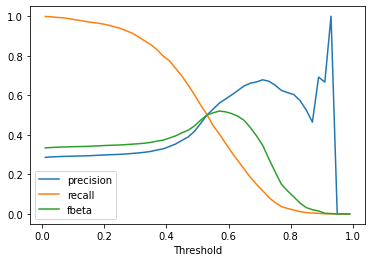

In [152]:
th_values = [i / 100. for i in range(1, 100, 2)]
precision = []
recall = []
fbeta = []

for th in th_values:

    batch_size = 1
    test_dl = flat_data_loader(test_set, batch_size)
    test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl, batch_size)

    pred = (test_pred > th).astype(int)

    if sum(pred) == 0:
        precision.append(0)
        recall.append(0)
        fbeta.append(0)
    else:
        precision.append(metrics.precision_score(test_true, pred))
        recall.append(metrics.recall_score(test_true, pred))
        fbeta.append(metrics.fbeta_score(test_true, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, fbeta, label="fbeta")
plt.xlabel("Threshold")
plt.legend()
plt.show()